In [139]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
import arch

## 1. Importing Data

In [8]:
# Importing Data
bit_data = yf.download(tickers = 'BTC-USD', start = "2020-04-01", end = "2021-01-01", interval = '1d')
gld_data = yf.download(tickers = 'GLD', start = "2020-04-01", end = "2021-01-01", interval = '1d')
vgk_data = yf.download(tickers = 'VGK', start = "2020-04-01", end = "2021-01-01", interval = '1d')

# Concatenating the adjusted close prices together
adj_close_data = pd.DataFrame(columns = ['BTC', 'GLD', 'VGK'])
adj_close_data['BTC'] = bit_data['Adj Close']
adj_close_data['GLD'] = gld_data['Adj Close']
adj_close_data['VGK'] = vgk_data['Adj Close']

# Filling NaN Values with forward-filling
adj_close_data.fillna(method = "ffill", axis = 0, inplace = True)

adj_close_data

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


,BTC,GLD,VGK
Date,,,
2020-03-31,6438.644531,148.050003,41.333157
2020-04-01,6606.776367,149.449997,39.518623
2020-04-02,6793.624512,151.899994,40.273083
2020-04-03,6733.387207,152.649994,39.432674
2020-04-04,6867.527344,152.649994,39.432674
...,...,...,...
2020-12-27,26272.294922,176.350006,58.935150
2020-12-28,27084.808594,175.710007,59.336601
2020-12-29,27362.437500,176.350006,59.767429


## 2. Data Processing and Calculating Returns

In [9]:
ret_data = pd.DataFrame(columns = ['BTC', 'GLD', 'VGK'])

# Calculating daily returns for GOLD ETF
ret_data['BTC'] = np.log(adj_close_data['BTC']) - np.log(adj_close_data['BTC'].shift(1))

# Calculating daily returns for GOLD ETF
ret_data['GLD'] = np.log(adj_close_data['GLD']) - np.log(adj_close_data['GLD'].shift(1))

# Calculating daily returns for EQUITY ETF
ret_data['VGK'] = np.log(adj_close_data['VGK']) - np.log(adj_close_data['VGK'].shift(1))

ret_data.dropna(inplace = True)
ret_data

,BTC,GLD,VGK
Date,,,
2020-04-01,0.025778,0.009412,-0.044893
2020-04-02,0.027889,0.016261,0.018911
2020-04-03,-0.008906,0.004925,-0.021089
2020-04-04,0.019726,0.000000,0.000000
2020-04-05,-0.011187,0.000000,0.000000
...,...,...,...
2020-12-27,-0.006251,0.000000,0.000000
2020-12-28,0.030458,-0.003636,0.006789
2020-12-29,0.010198,0.003636,0.007235


## 3. Data Summaries Extreme Values

Here we use the Z Score method for finding the extreme values, meaning that when a values is 3 standard deviations away from the mean of our data series we consider that an extreme, probably rare, realization of the data generating process.

In [10]:
# 3.1 Calculating total returns of assets for the given period
btc_tot_ret = ret_data['BTC'].sum()
gld_tot_ret = ret_data['GLD'].sum()
vgk_tot_ret = ret_data['VGK'].sum()

print("Bitcoin's return for the given period is: {} %".format(np.round(btc_tot_ret*100, 3)))
print("Gold ETF's return for the given period is: {} %".format(np.round(gld_tot_ret*100, 3)))
print("Equity ETF's return for the given period is: {} %".format(np.round(vgk_tot_ret*100, 3)))
print("")

# 3.2 Computing the kurtosis of each return series 
btc_kurt = ret_data['BTC'].kurtosis()
gld_kurt = ret_data['GLD'].kurtosis()
vgk_kurt = ret_data['VGK'].kurtosis()

print("Bitcoin's kurtosis for the given period is: {}".format(btc_kurt))
print("Gold ETF's kurtosis for the given period is: {}".format(gld_kurt))
print("Equity ETF's kurtosis for the given period is: {}".format(vgk_kurt))
print("")

# 3.3 - 3.4 Using z-score method for finding extreme values

# BTC 
btc_high_bound =  ret_data['BTC'].mean() + 3*ret_data['BTC'].std()
btc_low_bound  =  ret_data['BTC'].mean() - 3*ret_data['BTC'].std()
btc_outliers = ret_data['BTC'][(ret_data['BTC'] >= btc_high_bound) | (ret_data['BTC'] <= btc_low_bound)]
print("BTC outlier returns are: ")
print(btc_outliers*100)

# GLD 
gld_high_bound =  ret_data['GLD'].mean() + 3*ret_data['GLD'].std()
gld_low_bound  =  ret_data['GLD'].mean() - 3*ret_data['GLD'].std()
gld_outliers = ret_data['GLD'][(ret_data['GLD'] >= gld_high_bound) | (ret_data['GLD'] <= gld_low_bound)]
print("GLD outlier returns are: ")
print(gld_outliers*100)

# VGK 
vgk_high_bound =  ret_data['VGK'].mean() + 3*ret_data['VGK'].std()
vgk_low_bound  =  ret_data['VGK'].mean() - 3*ret_data['VGK'].std()
vgk_outliers = ret_data['VGK'][(ret_data['VGK'] >= vgk_high_bound) | (ret_data['VGK'] <= vgk_low_bound)]
print("VGK outlier returns are: ")
print(vgk_outliers*100)

Bitcoin's return for the given period is: 150.504 %
Gold ETF's return for the given period is: 18.625 %
Equity ETF's return for the given period is: 35.56 %

Bitcoin's kurtosis for the given period is: 2.742976185262016
Gold ETF's kurtosis for the given period is: 7.800406418235283
Equity ETF's kurtosis for the given period is: 4.094602787923698

BTC outlier returns are: 
Date
2020-04-29    11.984141
2020-05-10    -9.133875
2020-07-27    10.400867
2020-09-03   -10.802491
2020-11-05     9.741581
2020-11-26    -8.820525
Name: BTC, dtype: float64
GLD outlier returns are: 
Date
2020-08-11   -5.518973
2020-08-19   -3.207438
2020-11-09   -4.528086
Name: GLD, dtype: float64
VGK outlier returns are: 
Date
2020-04-01   -4.489296
2020-04-06    4.822487
2020-04-15   -4.173799
2020-05-18    4.420724
2020-06-11   -6.042095
2020-10-28   -3.935259
Name: VGK, dtype: float64


### [ THE SECTION'S TITLE]


--- EXPLAIN THE THEORY BEHIND YOUR IMPLEMENTATION HERE (IF NEEDED) ---
#### Header One 

#### Header Two

In [11]:
# USE HASHTAGS TO DIVIDE YOUR CODE INTO READABLE CHUNKS OR YOU CAN ADDRESS EACH PROMPT SEPERATELY
# 4.1 (EXAMPLE)






##### Interpretation of the Results

--- COMMENT ON YOUR RESULTS ---

## 4. Data Comparison Copulas

#### 4.1 Pick 2 of the series  that had the most extreme values.
Here, we chose ETF and Bitcoin given that they had the most extreme values.

In [119]:
# Utility method to calculate the returns of a provided quarter
import warnings
warnings.filterwarnings("ignore")

def get_data(df, year_start, year_end, month_start, month_end, column):
    return df[(df.index >= f"{year_start}-{month_start:02d}-01") & (df.index < f"{year_end}-{month_end:02d}-01")][column]    

#### 4.2 Graph the returns of those 2 series on an x-y plot.  Feel free to use either an individual quarter, or several quarters.


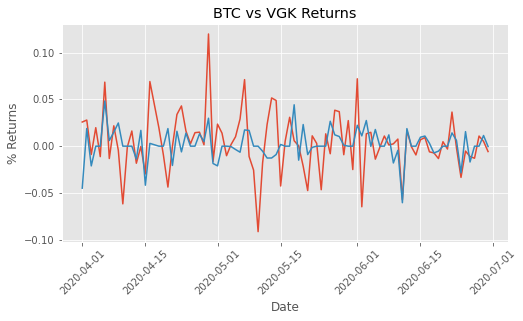

In [120]:
import matplotlib.pyplot as plt
# Change color theme
plt.style.use('ggplot')

#Extract quarter 2 data to be plotted
btc_q2 = get_data(ret_data, 2020, 2020, 4, 7, "BTC").reset_index()
equities_q2 = get_data(ret_data, 2020, 2020, 4, 7, "VGK").reset_index()

# Plot figure
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(btc_q2["Date"], btc_q2["BTC"])
ax.plot(equities_q2["Date"], equities_q2["VGK"])

# Setting the title
ax.set_title("BTC vs VGK Returns")

# Setting the ylabels and xlabels
ax.set_ylabel('% Returns')
ax.set_xlabel('Date')

# Rotate xticks
plt.xticks(rotation = 45)

plt.show()

#### 4.3 Fit a non-Gaussian copula to the returns of those 2 series.  Some possibilities are Student's T, Clayton, Gumbel, choose your own, …


In [101]:
from copulalib.copulalib import Copula
from array import array 

# Data and histograms
def plotData(x_value, y_value):

    fig = plt.figure()
    fig.add_subplot(2,2,1)
    plt.hist(x_value,bins=20,color='green',alpha=0.8,align='mid')
    plt.title('X variable distribution')
    fig.add_subplot(2,2,3)
    plt.scatter(x_value,y_value,marker="o",alpha=0.8)
    fig.add_subplot(2,2,4)
    plt.title('Joint X,Y')
    plt.hist(y_value,bins=20,orientation='horizontal',color='red',alpha=0.8,align='mid')
    plt.title('Y variable distribution')    
    plt.show()
    
# Generate Copula
def generateCopulas(x_value, y_value):

    fig = plt.figure()
    clayton = Copula(x_value,y_value,family='clayton')
    uc,vc = clayton.generate_uv(1000)
    fig.add_subplot(2,2,2)
    plt.scatter(uc,vc,marker='.',color='red')
    plt.ylim(0,1)
    plt.xlim(0,1)
    plt.title('Clayton copula')
    plt.show()

Non-Gaussian Coupula of BTC

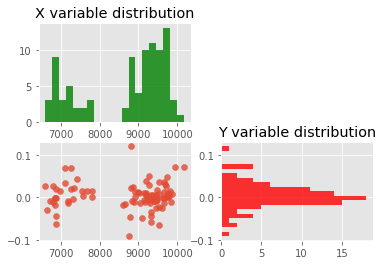

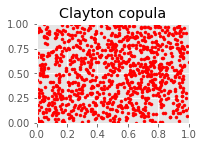

In [121]:
q2_btc_closing = get_data(adj_close_data, 2020, 2020, 4, 7, "BTC").reset_index()["BTC"]
q2_btc_returns = get_data(ret_data, 2020, 2020, 4, 7, "BTC").reset_index()["BTC"]

plotData(q2_btc_closing, q2_btc_returns)
generateCopulas(q2_btc_closing, q2_btc_returns)

Non-Gaussian Coupula of VGK

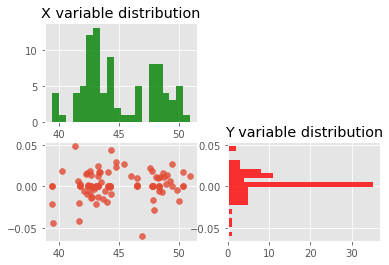

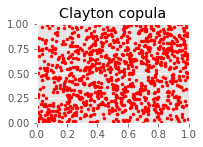

In [122]:
q2_vgk_closing = get_data(adj_close_data, 2020, 2020, 4, 7, "VGK").reset_index()["VGK"]
q2_vgk_returns = get_data(ret_data, 2020, 2020, 4, 7, "VGK").reset_index()["VGK"]

plotData(q2_vgk_closing, q2_vgk_returns)
generateCopulas(q2_vgk_closing, q2_vgk_returns)

## 6. Category 2 Models: Just use 2 variables: the one you are trading, and an additional (called exogeneous variable) to enhance prediction

#### 6.1 Use the same series as you did in the previous question
 we will choose ETF and Bitcoin.

In [134]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.varmax import VARMAX

def fit_arima(data, exog= None):
    model = ARIMA(data, exog=exog, order=(2,0,2))
    model_fit = model.fit()
    return model_fit

def fit_varmax(data, exog= None):
    model = VARMAX(data, exog=exog, order=(2,1))
    model_fit = model.fit()
    return model_fit

#### 6.2 Use Q2 data for estimation, and Q3 data for evaluating performance.

The returns is approximately 101%

In [123]:
q2_btc_returns = get_data(ret_data, 2020, 2020, 4, 7, "BTC").reset_index()["BTC"]
q2_vgk_returns = get_data(ret_data, 2020, 2020, 4, 7, "VGK").reset_index()["VGK"]
q3_btc_returns = get_data(ret_data, 2020, 2020, 7, 10, "BTC").reset_index()["BTC"]
q3_vgk_returns = get_data(ret_data, 2020, 2020, 7, 10, "VGK").reset_index()["VGK"]

model = fit_arima(q2_btc_returns, q2_vgk_returns)
return_pred = model.predict(exog=q3_vgk_returns, start=q2_btc_returns.shape[0], end=q2_btc_returns.shape[0] + q3_btc_returns.shape[0] - 1).values
signal = np.where(return_pred > 0, 1, -1)
return_q3 = np.product(q3_btc_returns * signal + 1) - 1
return_q3

1.0135675110145441

#### 6.3 Repeat, using Q3 data for estimation, and Q4 data for evaluating performance

The returns is approximately 44.3%

In [127]:
q3_btc_returns = get_data(ret_data, 2020, 2020, 7, 10, "BTC").reset_index()["BTC"]
q3_vgk_returns = get_data(ret_data, 2020, 2020, 7, 10, "VGK").reset_index()["VGK"]
q4_btc_returns = get_data(ret_data, 2020, 2021, 10, 1, "BTC").reset_index()["BTC"] 
q4_vgk_returns = get_data(ret_data, 2020, 2021, 10, 1, "VGK").reset_index()["VGK"] 

model = fit_arima(q3_btc_returns, q3_vgk_returns)
return_pred = model.predict(exog=q4_vgk_returns, start=q3_btc_returns.shape[0], end=q3_btc_returns.shape[0] + q4_btc_returns.shape[0] - 1).values
signal = np.where(return_pred > 0, 1, -1)
return_q4 = np.product(q4_btc_returns * signal + 1) - 1
return_q4


0.4431098827855444

#### 6.4 Build 3 trading strategies. + 6.5 The 1st strategy should include a form of VAR or VARMA.  

In [ ]:
## No idea

#### 6.6 The 2nd strategy should include multivariate GARCH.  There are several possibilities.  

Here we combine the use of Garch with Arima to derive at the ARMA-GARCH model.

In [140]:
def fit_garch(data, garch_type="GARCH"):
    if garch_type == "TARCH":
        garch = arch.arch_model(data, vol='TGARCH', p=1, o=1, q=1, power=1)
    else:
        garch = arch.arch_model(data, vol=garch_type, p=1, o=0, q=1)
    garch_fitted = garch.fit()
    print(garch_fitted.summary())
    if garch_type != "FIGARCH":
        omega = garch_fitted.params["omega"]
        alpha = garch_fitted.params["alpha[1]"]
        beta = garch_fitted.params["beta[1]"]
        print(f"Unconditional variance: {omega/(1 - alpha - beta)}")
    return garch_fitted

In [172]:
import pmdarima
import arch

q2_btc_returns = get_data(ret_data, 2020, 2020, 4, 7, "BTC").reset_index()["BTC"]
model = fit_arima(q2_btc_returns, q2_vgk_returns)
return_pred = model.predict(exog=q3_vgk_returns, start=q2_btc_returns.shape[0], end=q2_btc_returns.shape[0] + q3_btc_returns.shape[0] - 1).values
signal = np.where(return_pred > 0, 1, -1)
return_q3 = np.product(q3_btc_returns * signal + 1) - 1
return_q3

# fit a GARCH(1,1) model on the residuals of the ARIMA model
model = fit_garch(q2_btc_returns)
garch_forecast = model.forecast(horizon=1)
predicted_et = garch_forecast.mean['h.1'].iloc[-1]

return_q3 = return_q3 + predicted_et
print("The returns is", return_q3)

Iteration:      1,   Func. Count:      6,   Neg. LLF: 101.49247709970281
Iteration:      2,   Func. Count:     15,   Neg. LLF: 68.00466295163567
Iteration:      3,   Func. Count:     24,   Neg. LLF: -184.0820913883987
Iteration:      4,   Func. Count:     29,   Neg. LLF: -184.08220401787744
Iteration:      5,   Func. Count:     34,   Neg. LLF: -184.08226945143187
Iteration:      6,   Func. Count:     39,   Neg. LLF: -184.08229004340967
Iteration:      7,   Func. Count:     44,   Neg. LLF: -184.0822916265253
Iteration:      8,   Func. Count:     48,   Neg. LLF: -184.08229162627197
Optimization terminated successfully    (Exit mode 0)
            Current function value: -184.0822916265253
            Iterations: 8
            Function evaluations: 48
            Gradient evaluations: 8
                     Constant Mean - GARCH Model Results                      
Dep. Variable:                    BTC   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-

#### 6.7 The 3rd strategy should attempt to include cointegration.  Note that if cointegration is not found, then justify the lack of existence for cointegration in quantitative terms.

Given that p-value < 0.01 for all tests, we conclude that there are cointegrating vectors.

In [170]:
from statsmodels.tsa.stattools import adfuller, coint

q2_btc_returns = get_data(ret_data, 2020, 2020, 4, 7, "BTC").reset_index()["BTC"]
q2_vgk_returns = get_data(ret_data, 2020, 2020, 4, 7, "VGK").reset_index()["VGK"]
q2_gold_returns = get_data(ret_data, 2020, 2020, 4, 7, "GLD").reset_index()["GLD"]

print(coint(q2_btc_returns, np.array([q2_vgk_returns, q2_gold_returns]).T))
print(coint(q2_vgk_returns, np.array([q2_btc_returns, q2_gold_returns]).T))
print(coint(q2_gold_returns, np.array([q2_vgk_returns, q2_btc_returns]).T))

(-3.7219743379755807, 0.05249239182963255, array([-4.46005898, -3.83820607, -3.52247298]))
(-5.508525153998414, 8.719628627588787e-05, array([-4.46005898, -3.83820607, -3.52247298]))
(-9.967914411796926, 1.2560441593036165e-16, array([-4.46005898, -3.83820607, -3.52247298]))
